<a href="https://colab.research.google.com/github/jodowd7/my_personal_work/blob/master/37_ridimab_jodowd_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instructions for downloading images:**

1. First install these tools: MicroDicom-3.9.5-win32.exe and NBIA Data Retriever-4.1.msi found at: https://drive.google.com/drive/folders/1ZIF9Xvf_uJE9hredUu0YjLQVLHA4iF6W?usp=sharing 
2. Navigate to the files where benign vs malignant images exist: https://www.cancerimagingarchive.net/nbia-search/?CollectionCriteria=SPIE-AAPM%20Lung%20CT%20Challenge . Click on the CLOSE button (bottom right of screen). SEARCH IMAGES and then under COLLECTIONS, pick SPIE-AAPM Lung CT Challenge. Now look under SEARCH RESULTS tab. Click on the CART icon for as many images we decide we need for training and testing. We will let our algorithms/model split the "training" data for us into "train" and "test". So perhaps we just make sure we get same number of images for benign "BE" and malignant "LC". I'm going to start off downloading CT-Training-BE001(251 images) & CT-Training-BE002 (350 images) and then for malignant the CT-Training-LC001 (285 images) & CT-Training-LC002 (366 images). Once downloaded we can probably reduce the image count to 600 images each (600 benign and 600 malignant for the algorithm to split into train and test proportions etc.).  NOTE History behind these images: Description of SPIE-AAPM Lung CT Challenge: As part of the 2015 SPIE Medical Imaging Conference, SPIE – with the support of American Association of Physicists in Medicine (AAPM) and the National Cancer Institute (NCI) – conducted a “Grand Challenge” on quantitative image analysis methods for the diagnostic classification of malignant and benign lung nodules.
3. Now look for the DOWNLOAD tab and click on it to download. 

4. You should see this file in your downloads folder: manifest-1630362175891.tcia. Right click and select OPEN WITH "NBIA DATA RETRIEVER" tool (that you already installed from step 1).
5. Pick a local folder to download the data so you can access it later and then START the download by clicking on the START button in the NBIA DATA RETRIEVER tool.
6. Using the MicroDicom viewer tool (that you already installed from step 1), you can select ALL your DICOM files and convert to a equally high quality JPG.


# **Below is the Supervised SVM model code that will classify images.**

In [1]:
# Pip install these first
# !pip install pydicom
# !pip install opencv-python
# NOTE: This ran once already and doesn't need to install again

In [2]:
# Import Libraries
import pydicom as dicom
import os
import cv2
import PIL # optional
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [3]:
# Algorithm to convert Dicom DCM files to JPG
# NOTE: Tried an algorithm approach but the quality of the jpg wasn't good
# The MicroDicom viewer tool provides a way to mass select dcm images and convert at once to
# very high quality jpg. It only makes sense to use this as we need these jpg images to resemble
# the original high quality of the Dicom dcm files so that the model can distinguish the normal lungs
# from the unhealthy, tumor filled lungs.

## UPDATE: I tried the SVM model below with DCM files (not converted to JPG) and it worked; give it a try and see if doesn't function properly, convert to JPG.
## HOWEVER, we might as well convert the DCM files into JPG because the Unsupervised CNN model will only take the JPG files.

In [4]:
# Data Pre-processing Stage - Convert imagery data to flat data for SVM model
# NOTE: for this to work properly, we need to manually create folders named exactly like the categories names
# below such as 'lung-tumor' and 'lung-healthy' in the SAME directory as this Jupyter Notebook ipynb file 
# and then place the jpg files we know are the ones with a tumor in the 'lung-tumor' folder and those jpg files
# we know are healthy in the 'lung-healthy' folder. This is how we prepare the model for labeling.

Categories=['sample_data/lung-benign','sample_data/lung-malignant']
flat_data_arr=[] #input array
target_arr=[] #output array
datadir='' 
#path which contains all the categories of images
for i in Categories:
    
    print(f'loading... category : {i}')
    path=os.path.join(datadir,i)
    for img in os.listdir(path):
        img_array=imread(os.path.join(path,img))
        img_resized=resize(img_array,(150,150,3))
        flat_data_arr.append(img_resized.flatten())
        target_arr.append(Categories.index(i))
    print(f'loaded category:{i} successfully')
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data) #dataframe
df['Target']=target
x=df.iloc[:,:-1] #input data 
y=df.iloc[:,-1] #output data

loading... category : sample_data/lung-benign
loaded category:sample_data/lung-benign successfully
loading... category : sample_data/lung-malignant
loaded category:sample_data/lung-malignant successfully


In [5]:
# Create Supervised SVM.SVC model
param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
svc=svm.SVC(probability=True)
model=GridSearchCV(svc,param_grid)

In [6]:
# Split, Train, Test, Validate the data 
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=77,stratify=y)
print('Data split is complete.')

# Train the SVM (SVC) model
model.fit(x_train,y_train)
print('The model is now trained with the images.')

Data split is complete.


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


The model is now trained with the images.


In [7]:
# model data prediction vs actual
y_pred=model.predict(x_test)
print("The predicted data is:")
print(y_pred)
print("The actual data is:")
print(np.array(y_test))
print(f"The model is {accuracy_score(y_pred,y_test)*100}% accurate")

The predicted data is:
[1 0 1]
The actual data is:
[0 1 1]
The model is 33.33333333333333% accurate


Enter URL path of Image:/content/sample_data/lung-malignant/malignant2.jpg


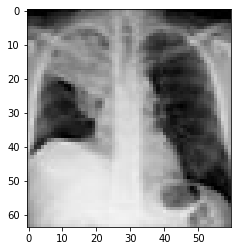

sample_data/lung-benign = 19.84508584220006%
sample_data/lung-malignant = 80.15491415779992%
The predicted image is: sample_data/lung-malignant


In [8]:
# Test out the code by providing the url location where image resides
url=input('Enter URL path of Image:')
img=imread(url)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
probability=model.predict_proba(l)
for ind,val in enumerate(Categories):
    print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is: "+Categories[model.predict(l)[0]])

# NOTE: So far as a 'smoke test', we have only trained 3 benign and 3 malignant images. 
# Accuracy is only at 33.33%; this will improve with more images added for training.
# For URL path: try entering this: /content/sample_data/lung-malignant/malignant2.jpg  (example jpg to test against)
# NOTE: Remember if you get bad results, this will improve as we train with more images.

## **Below is Unsupervised model Part B - Convolutional Neural Network (CNN) model** 

## **NOTE:  For this model, we must convert dcm images to jpg format for it to function properly.**

In [9]:
# Installation of pytorch
# conda install pytorch==1.7.1 torchvision==0.8.2 torchaudio==0.7.2 cpuonly -c pytorch
# Looks like we don't need this step as PyTorch is already installed

In [10]:
# Import Libraries

%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.9.0+cu102


In [11]:
# Data Pre-processing Stage
class_names = ['lung-benign', 'lung-malignant']
root_dir = '__data set'
source_dirs = ['lung-benign', 'lung-malignant']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('jpg')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

In [12]:
# Data Processing Stage

class ChestDiagnosis(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('jpg')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['lung-benign', 'lung-malignant']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

In [13]:
# Image Transformations Step

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [14]:
# Split into Training data preparation step

train_dirs = {
    'lung-benign': 'sample_data/lung-benign',
    'lung-malignant': 'sample_data/lung-malignant'
}

train_dataset = ChestDiagnosis(train_dirs, train_transform)

Found 6 lung-benign examples
Found 6 lung-malignant examples


In [15]:
# Split into Testing data preparation step

test_dirs = {
    'lung-benign': 'sample_data/lung-benign',
    'lung-malignant': 'sample_data/lung-malignant'
}

test_dataset = ChestDiagnosis(test_dirs, test_transform)

Found 6 lung-benign examples
Found 6 lung-malignant examples


In [16]:
# Data split loading preparation step

batch_size = 5

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 3
Number of test batches 3


In [17]:
# Data Visualations preliminary step

class_names = train_dataset.class_names


def display_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 5, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()


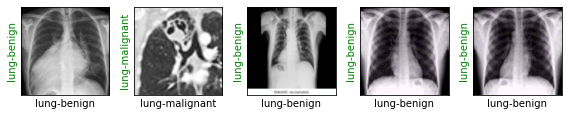

In [18]:
images, labels = next(iter(dl_train))
display_images(images, labels, labels)

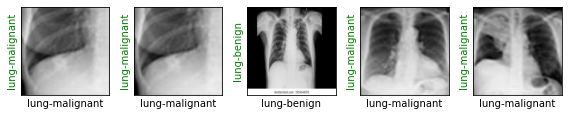

In [19]:
images, labels = next(iter(dl_test))
display_images(images, labels, labels)

In [20]:
# Creating the Unsupervised CNN Model

CNN = torchvision.models.resnet18(pretrained=True)

print(CNN)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
CNN.fc = torch.nn.Linear(in_features=512, out_features=2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN.parameters(), lr=3e-5)

In [22]:
# Set up predictions function

def display_predictions():
    CNN.eval()
    images, labels = next(iter(dl_test))
    outputs = CNN(images)
    _, preds = torch.max(outputs, 1)
    display_images(images, labels, preds)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


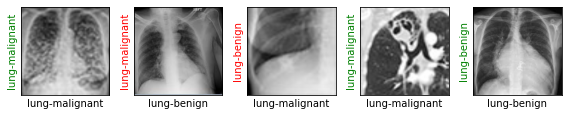

In [23]:
# Using predictions function, make predictions prior to model training 
# NOTE: following model training, these predictions will improve

display_predictions()

In [24]:
# Train the CNN Model

def training(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        CNN.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = CNN(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                CNN.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = CNN(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                display_predictions()

                CNN.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 0.5702, Accuracy: 0.6667


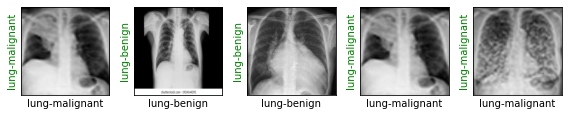

Training Loss: 0.5148
Training complete..
CPU times: user 5.23 s, sys: 445 ms, total: 5.67 s
Wall time: 5.58 s


In [25]:
# Actual training begins

%%time

training(epochs=1)

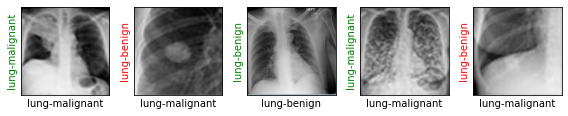

In [26]:
# Display the final results
# NOTE: currently we are only training with 3 benign and 3 malignant images and testing with 3 benign and 3 malignant images
# Display 5 predictions below results about 60% accurate; this will improve as we add more images to train with
# this was just a trial run as sort of a 'smoke screen' test

display_predictions()